# Capstone Project: Police Call Outcome Prediction: Year 2021

This notebook explores and analyzes police call data in the city of San Jose, California, with the goal of predicting whether the outcome will be an arrest, a citation, or neither. The dataset contains various features such as call type, location, and final disposition. Models like Logistic Regression, Random Forest, and others are evaluated for this task.

## Data Loading and Initial Exploration

In this section, we load the police call dataset for analysis and perform some initial data exploration.

In [3]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import warnings, os, sys
warnings.simplefilter(action='ignore', category=FutureWarning)  # Ignore future warnings

import importlib

import model_utils
importlib.reload(model_utils)

import collections
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import folium
import numpy as np
from folium.plugins import HeatMap
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
import joblib
import keras_tuner as kt
from tensorflow import keras

import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import time

### Data Loading

Here, we load the police call data for the year 2021 from a CSV file.

#### Data Source
* San Jose Police Calls For Service: https://data.sanjoseca.gov/dataset/police-calls-for-service.

In [5]:
years = [2021]
year = "2021"

all_police_df = model_utils.load_data(years)

print(f'length of dataframe = {len(all_police_df)}')

length of dataframe = 302119


### Initial Data Exploration

We explore a sample of the data and generate summary statistics to get an idea of its structure and contents.

In [7]:
all_police_df.sample(5)

,CDTS,EID,START_DATE,CALL_NUMBER,PRIORITY,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,LATITUDE,LONGITUDE,neighborhood
216646,20210919040739PD,8779713,9/19/2021 12:00:00 AM,P212620195,4,9/19/2021 12:00:00 AM,9/19/2021 12:00:00 AM,03:16:42,415M,"DISTURBANCE, MUSIC",CAN,Canceled,[400]-[500] PERRYMONT AV,San Jose,CA,37.300773,-121.869361,The Plant
195236,20210825223548PD,8747291,8/25/2021 12:00:00 AM,P212370882,4,8/25/2021 12:00:00 AM,8/25/2021 12:00:00 AM,21:23:58,415M,"DISTURBANCE, MUSIC",CAN,Canceled,[200]-[300] S JACKSON AV,San Jose,CA,37.347310,-121.832962,Dobern and Capitol Park
240060,20211016025329PD,8815508,10/16/2021 12:00:00 AM,P212890114,2,10/16/2021 12:00:00 AM,10/16/2021 12:00:00 AM,02:29:10,WELCKEMS,WELFARE CHECK (COMBINED EVENT),CAN,Canceled,[100]-[200] N 4TH ST,San Jose,CA,37.354977,-121.900318,Civic Center
208188,20210909202820PD,8767396,9/9/2021 12:00:00 AM,P212520840,3,9/9/2021 12:00:00 AM,9/9/2021 12:00:00 AM,20:06:00,1033A,"ALARM, AUDIBLE",CAN,Canceled,[800]-[900] POINT CREEK CT,San Jose,CA,37.383671,-121.848096,Penitencia Creek
123563,20210603174635PD,8636439,6/3/2021 12:00:00 AM,P211540611,3,6/3/2021 12:00:00 AM,6/3/2021 12:00:00 AM,13:53:34,10851,STOLEN VEHICLE,R,Report taken,[2100]-[2200] TULLY RD,San Jose,CA,37.328724,-121.816350,Meadow Fair


In [9]:
all_police_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302119 entries, 0 to 302118
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CDTS              302119 non-null  object 
 1   EID               302119 non-null  int64  
 2   START_DATE        302119 non-null  object 
 3   CALL_NUMBER       302119 non-null  object 
 4   PRIORITY          302119 non-null  int64  
 5   REPORT_DATE       302119 non-null  object 
 6   OFFENSE_DATE      302119 non-null  object 
 7   OFFENSE_TIME      302119 non-null  object 
 8   CALLTYPE_CODE     302119 non-null  object 
 9   CALL_TYPE         302119 non-null  object 
 10  FINAL_DISPO_CODE  302119 non-null  object 
 11  FINAL_DISPO       302119 non-null  object 
 12  ADDRESS           293112 non-null  object 
 13  CITY              302119 non-null  object 
 14  STATE             302119 non-null  object 
 15  LATITUDE          271738 non-null  float64
 16  LONGITUDE         27

In [10]:
all_police_df.describe()

,EID,PRIORITY,LATITUDE,LONGITUDE
count,3.021190e+05,302119.000000,271738.000000,271738.000000
mean,8.678600e+06,3.295503,37.322424,-121.871670
std,1.346496e+05,1.428692,0.042060,0.047263
min,8.444832e+06,1.000000,37.150332,-122.035696
25%,8.561760e+06,2.000000,37.300726,-121.902843
50%,8.677855e+06,3.000000,37.325134,-121.869952
75%,8.795038e+06,4.000000,37.349308,-121.838998
max,8.912981e+06,6.000000,37.534539,-121.635696


In [11]:
all_police_df.describe(include='object')

,CDTS,START_DATE,CALL_NUMBER,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,neighborhood
count,302119,302119,302119,302119,302119,302119,302119,302119,302119,302119,293112,302119,302119,270320
unique,300224,217,295467,365,365,80765,202,218,22,25,40145,1,1,295
top,20210812184930PD,5/15/2021 12:00:00 AM,P212140570,7/4/2021 12:00:00 AM,7/4/2021 12:00:00 AM,10:39:10,1195,VEHICLE STOP,N,No report required; dispatch record only,Not a valid geographical location in CAD.,San Jose,CA,Spartan Keyes and Wool Creek
freq,4,109325,5,1116,1116,16,32837,32837,140203,88336,798,302119,302119,8807


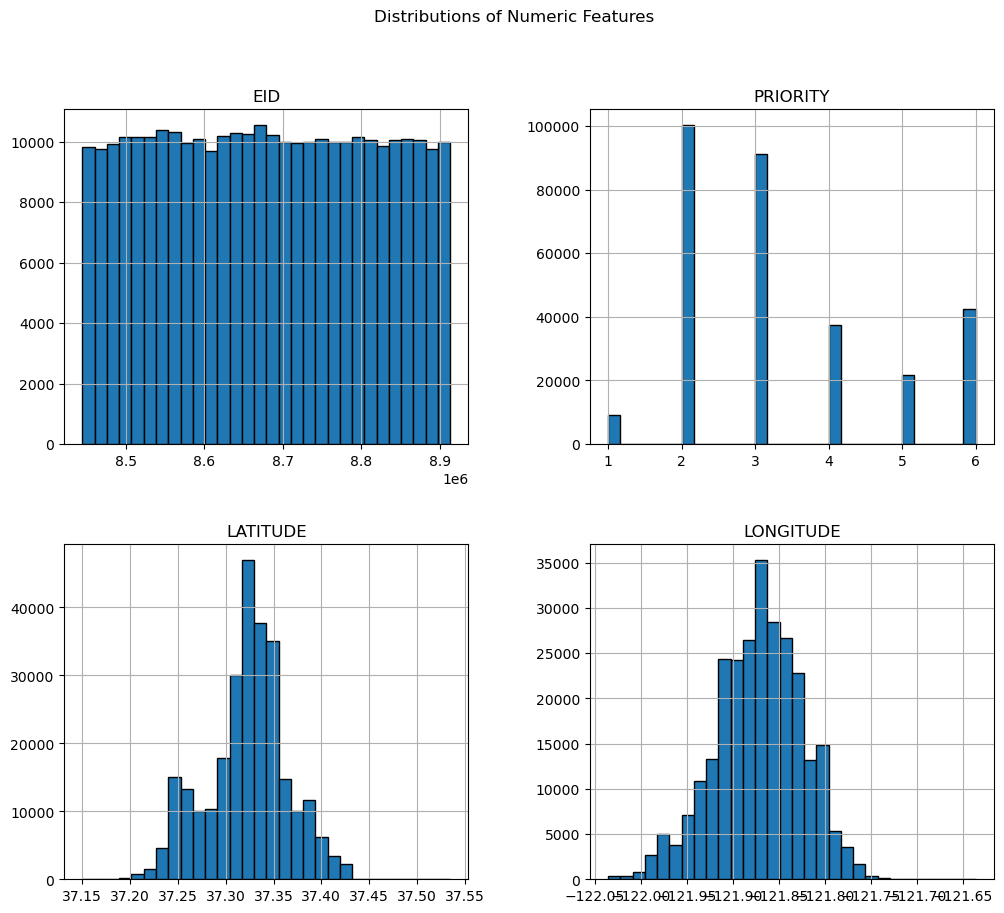

In [14]:
# Plot histograms for numeric columns
all_police_df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Distributions of Numeric Features')
plt.show()

In [17]:
missing_data = all_police_df.isnull().sum()
missing_data

CDTS                    0
EID                     0
START_DATE              0
CALL_NUMBER             0
PRIORITY                0
REPORT_DATE             0
OFFENSE_DATE            0
OFFENSE_TIME            0
CALLTYPE_CODE           0
CALL_TYPE               0
FINAL_DISPO_CODE        0
FINAL_DISPO             0
ADDRESS              9007
CITY                    0
STATE                   0
LATITUDE            30381
LONGITUDE           30381
neighborhood        31799
dtype: int64

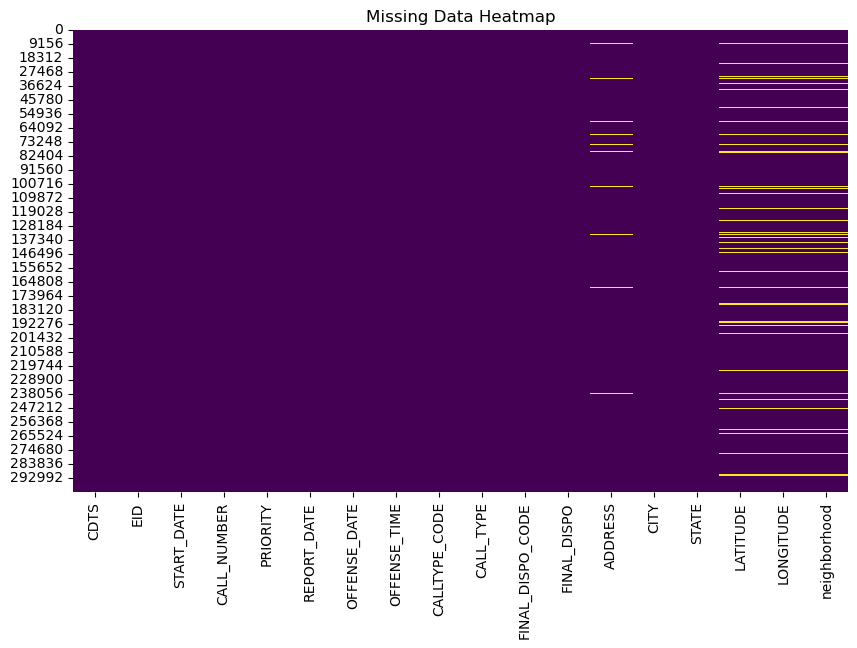

In [18]:
# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(all_police_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [20]:
for column in all_police_df.select_dtypes(include=['object']).columns:
    unique_values = all_police_df[column].nunique()
    print(f'{column}: {unique_values} unique values')

CDTS: 300224 unique values
START_DATE: 217 unique values
CALL_NUMBER: 295467 unique values
REPORT_DATE: 365 unique values
OFFENSE_DATE: 365 unique values
OFFENSE_TIME: 80765 unique values
CALLTYPE_CODE: 202 unique values
CALL_TYPE: 218 unique values
FINAL_DISPO_CODE: 22 unique values
FINAL_DISPO: 25 unique values
ADDRESS: 40145 unique values
CITY: 1 unique values
STATE: 1 unique values
neighborhood: 295 unique values


In [21]:
all_police_df['neighborhood'].value_counts()

neighborhood
Spartan Keyes and Wool Creek      8807
Little Saigon and Spring Brook    5185
Five Wounds-San Jose High         4495
Trimble Business Area             4415
Virginia and Martha               3913
                                  ... 
Houge Parker                        43
Santa Teresa Hills                  30
Alta Vista                          29
Linda Vista and Hillcrest           25
Meadowlands                         20
Name: count, Length: 295, dtype: int64

In [23]:
all_police_df['FINAL_DISPO_CODE'].value_counts()

FINAL_DISPO_CODE
N          140203
CAN         53453
R           32358
G           16690
D           13256
O            5969
DUPNCAN      5401
E            5075
GD           4901
A            4272
U            3977
H            3599
T            3072
C            2639
ADV          2523
B            2311
NR           1446
F             854
M              46
Z              42
TOT            16
P              16
Name: count, dtype: int64

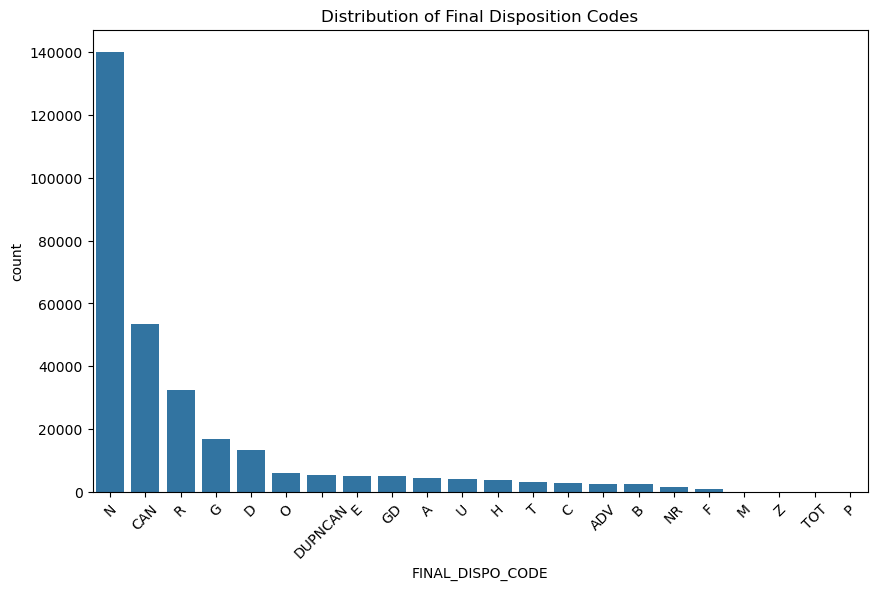

In [25]:
# Bar plot for target variable (FINAL_DISPO_CODE)
plt.figure(figsize=(10, 6))
sns.countplot(data=all_police_df, x='FINAL_DISPO_CODE', order=all_police_df['FINAL_DISPO_CODE'].value_counts().index)
plt.title('Distribution of Final Disposition Codes')
plt.xticks(rotation=45)
plt.show()

In [26]:
all_police_df['FINAL_DISPO'].value_counts()

FINAL_DISPO
No report required; dispatch record only            88336
Canceled                                            53453
No report required; dispatch r                      51867
Report taken                                        32358
No Disposition                                      12883
Gone on Arrival/unable to locate                    10327
Traffic Citation Issued, Hazardous Violation         9266
Gone on Arrival/unable to loca                       6363
Supplemental report taken                            5969
Arrest Made                                          4272
Traffic Citation Issued, Hazar                       3990
Unfounded event                                      3977
Traffic Citation Issued, Non-Hazardous Violation     3236
Turned over To (TOT)                                 3072
Criminal Citation                                    2639
Arrest by Warrant                                    2311
Courtesy Service/Citizen or agency assist            2161
Tr

In [27]:
# Create a mapping between FINAL_DISPO_CODE and FINAL_DISPO
final_dispo_mapping = dict(zip(all_police_df['FINAL_DISPO_CODE'], all_police_df['FINAL_DISPO']))
final_dispo_mapping

{'CAN': 'Canceled',
 'NR': 'No Response',
 'N': 'No report required; dispatch record only',
 'T': 'Turned over To (TOT)',
 'R': 'Report taken',
 'G': 'Gone on Arrival/unable to locate',
 'DUPNCAN': 'No Disposition',
 'D': 'Traffic Citation Issued, Hazardous Violation',
 'O': 'Supplemental report taken',
 'A': 'Arrest Made',
 'U': 'Unfounded event',
 'GD': 'No Disposition',
 'E': 'Traffic Citation Issued, Non-Hazardous Violation',
 'H': 'Courtesy Service/Citizen or agency assist',
 'F': 'Field Interview (F.I.) Completed',
 'C': 'Criminal Citation',
 'B': 'Arrest by Warrant',
 'ADV': 'No Disposition',
 'Z': 'No Disposition',
 'M': 'Stranded motorist assist',
 'TOT': 'No Disposition',
 'P': 'Prior case, follow-up activity only'}

In [28]:
call_type_code_mapping = dict(zip(all_police_df['CALLTYPE_CODE'], all_police_df['CALL_TYPE']))
call_type_code_mapping

{'415FC': 'DISTURBANCE, FIRECRACKERS',
 '602PC': 'TRESPASSING',
 '1033A': 'ALARM, AUDIBLE',
 '1057': 'FIREARMS DISCHARGED',
 '1033S': 'ALARM, SILENT',
 '415F': 'DISTURBANCE, FAMILY',
 '415': 'DISTURBANCE',
 '1062': 'MEET THE CITIZEN',
 '415M': 'DISTURBANCE, MUSIC',
 '242': 'BATTERY',
 '1195': 'VEHICLE STOP',
 '415W': 'DISTURBANCE, WEAPON',
 'SUSCIR': 'SUSPICIOUS CIRCUMSTANCES',
 '20002': 'MISDEMEANOR HIT AND RUN',
 '415EMS': 'DISTURBANCE (COMBINED EVENT)',
 '1066': 'SUSPICIOUS PERSON',
 '245': 'ASSAULT WITH DEADLY WEAPON',
 '459': 'BURGLARY (460)',
 '415A': 'DISTURBANCE, FIGHT',
 '647': 'VAGRANT',
 '10851': 'STOLEN VEHICLE',
 '415UNK': 'DISTURBANCE, UNKNOWN',
 'DVRO': 'VIOLATION OF PROTECTIVE ORDER',
 '417': 'BRANDISHING A WEAPON',
 'WELCKEMS': 'WELFARE CHECK (COMBINED EVENT)',
 '22500': 'PARKING VIOLATION',
 '1154': 'SUSPICIOUS VEHICLE',
 'WELCK': 'WELFARE CHECK',
 '1067X': 'FEMALE CALLING FOR HELP',
 '459VEH': 'VEHICLE BURGLARY',
 '422': 'CRIMINAL THREATS',
 '1046': 'SICK PERSON',
 '

## Focus on Target Dispositions

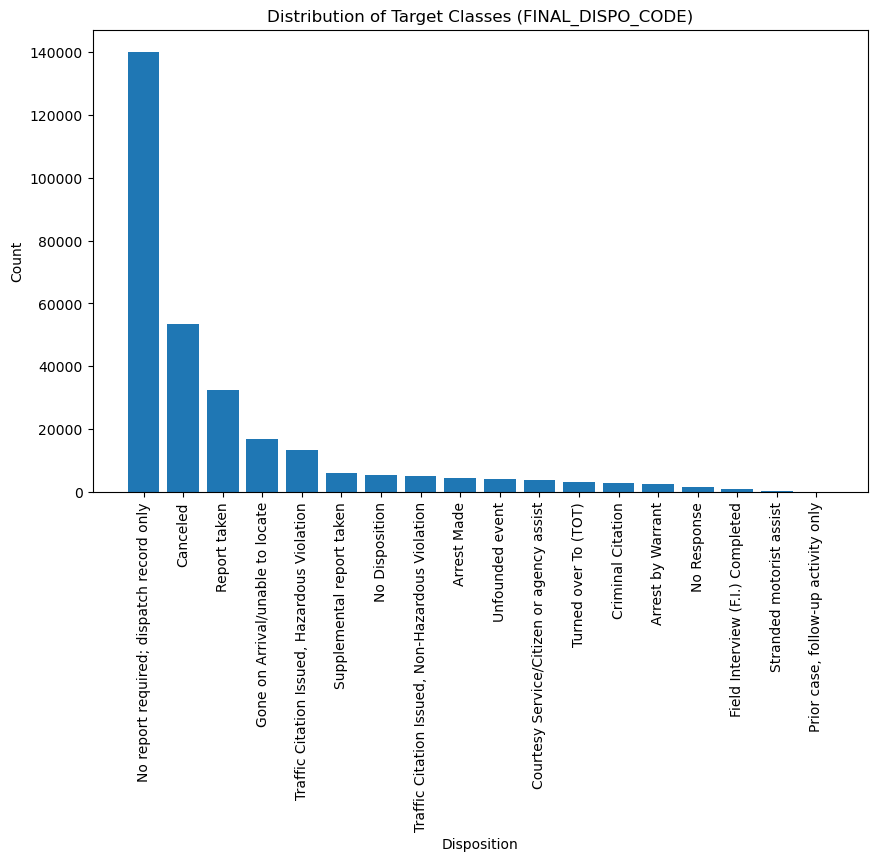

In [30]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['FINAL_DISPO_CODE'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [final_dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (FINAL_DISPO_CODE)')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

In [31]:
model_utils.transform_offense_date(all_police_df)

In [32]:
dispo_mapping = model_utils.calc_dispo_subset(all_police_df)
all_police_df['DISPO_SUBSET'].value_counts()

DISPO_SUBSET
Other    292897
A          4272
C          2639
B          2311
Name: count, dtype: int64

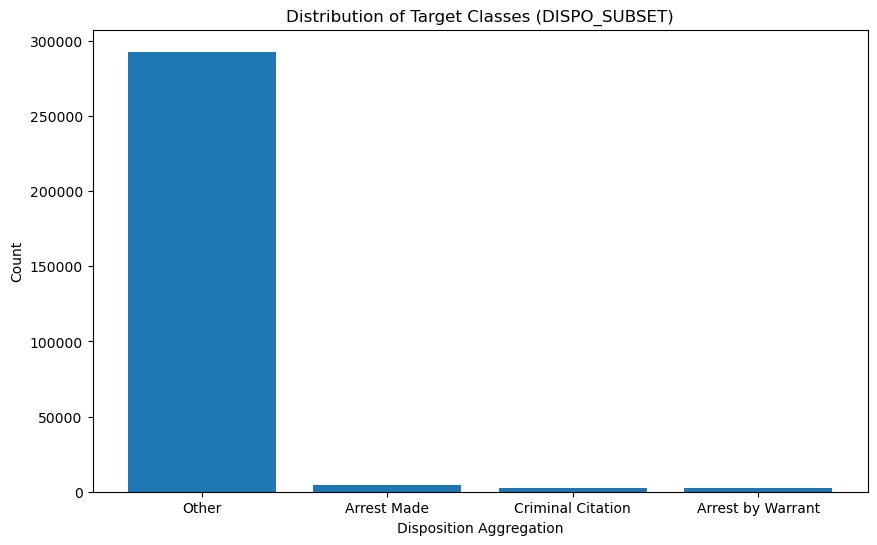

In [33]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['DISPO_SUBSET'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (DISPO_SUBSET)')
plt.xlabel('Disposition Aggregation')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.savefig('images/class_imbalance.png')
plt.show()

## Data Cleaning and Feature Engineering

In [35]:
police_calls_encoded = model_utils.clean_and_transform_data(all_police_df)

Police Calls Dataset: 302119 rows before cleaning, 270320 rows after cleaning.


In [36]:
police_calls_encoded.shape

(270320, 15)

In [38]:
police_calls_encoded

,PRIORITY,CALLTYPE_CODE,LATITUDE,LONGITUDE,neighborhood,OFFENSE_HOUR,OFFENSE_DAY_OF_WEEK,OFFENSE_MONTH,OFFENSE_YEAR,AFTER_COVID,DISPO_SUBSET,DISTANCE_FROM_CENTER,LATITUDE^2,LATITUDE LONGITUDE,LONGITUDE^2
0,4,415FC,2.496257,-2.129196,Alviso,0,4,1,2021,Yes,Other,0.123238,6.231299,-5.315020,4.533475
1,4,415FC,-2.229271,1.259221,La Colina,0,4,1,2021,Yes,Other,0.132218,4.969648,-2.807145,1.585638
4,4,415FC,-1.716485,0.192905,Steinbeck and Allen,0,4,1,2021,Yes,Other,0.091115,2.946319,-0.331119,0.037212
5,4,415FC,-0.676333,0.601164,Umbarger,0,4,1,2021,Yes,Other,0.061848,0.457427,-0.406587,0.361398
6,4,415FC,-1.555328,-0.888575,Sartortte and Rose,0,4,1,2021,Yes,Other,0.085434,2.419044,1.382025,0.789566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302113,3,23103,-1.631942,1.450259,Magic Sands Mobile Homes,0,4,12,2021,Yes,Other,0.118474,2.663234,-2.366737,2.103250
302114,2,FDAID,0.777977,-0.350453,Japantown and Luna Park,0,4,12,2021,Yes,Other,0.016950,0.605248,-0.272644,0.122817
302115,2,242,-2.030934,-0.842069,Belwood-Belgatos,0,4,12,2021,Yes,Other,0.104047,4.124693,1.710186,0.709080
302117,3,20002,1.143792,0.632597,Warm Springs,0,4,12,2021,Yes,Other,0.055153,1.308261,0.723560,0.400180


## Define X and Y

In [43]:
# load the encoder file
encoder = joblib.load('one_hot_encoder.pkl')

In [47]:
X_train, X_test, y_train, y_test, label_names, class_labels, X_train_resampled, y_train_resampled, _ = \
    model_utils.split_data(police_calls_encoded, dispo_mapping, encoder)

classes = ['A' 'B' 'C' 'Other']
(216256, 14)
(54064, 14)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']
Counter({3: 209536, 0: 3125, 2: 1890, 1: 1705})
Counter({3: 6720, 0: 3125, 2: 1890, 1: 1705})


In [50]:
X_train.shape

(216256, 529)

In [54]:
X_train

,PRIORITY,LATITUDE,LONGITUDE,DISTANCE_FROM_CENTER,LATITUDE^2,LATITUDE LONGITUDE,LONGITUDE^2,CALLTYPE_CODE_1033,CALLTYPE_CODE_1033A,CALLTYPE_CODE_1033CTX,...,neighborhood_Willow Glen South,neighborhood_Willow Glen West,neighborhood_Willow Vale,neighborhood_Willowmont,neighborhood_Winchester,neighborhood_Winchester Lynnhaven,neighborhood_Windmill Springs,neighborhood_Wooster and East Ct and West Ct,neighborhood_YB Lucretia,AFTER_COVID_Yes
140260,1.891948,-0.297436,-0.820267,-0.619320,-0.648956,0.370405,-0.229330,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1883,1.891948,0.543118,0.105954,-1.085869,-0.503075,0.200961,-0.690131,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
128334,0.491541,0.270295,-0.793154,-1.038909,-0.660771,-0.045195,-0.259837,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
194898,-0.208663,0.498076,-1.034002,-0.703458,-0.536419,-0.317639,0.047093,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
65387,-0.908867,1.864123,-0.163199,0.153867,1.760459,-0.126131,-0.679684,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214199,1.891948,-0.052304,0.943064,0.131718,-0.710395,0.102736,-0.076147,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
208692,1.891948,-0.080168,1.659908,1.114777,-0.707724,0.026036,1.227259,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
224701,-0.208663,0.326317,-0.409268,-1.574968,-0.637042,0.027849,-0.581629,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
108794,-0.208663,0.636415,0.906855,0.031569,-0.424813,0.671844,-0.122949,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


y_train distribution: Counter({3: 209536, 0: 3125, 2: 1890, 1: 1705})
y_test distribution: Counter({3: 52384, 0: 781, 2: 473, 1: 426})
y_train_resampled distribution: Counter({3: 209536, 0: 3125, 2: 1890, 1: 1705})


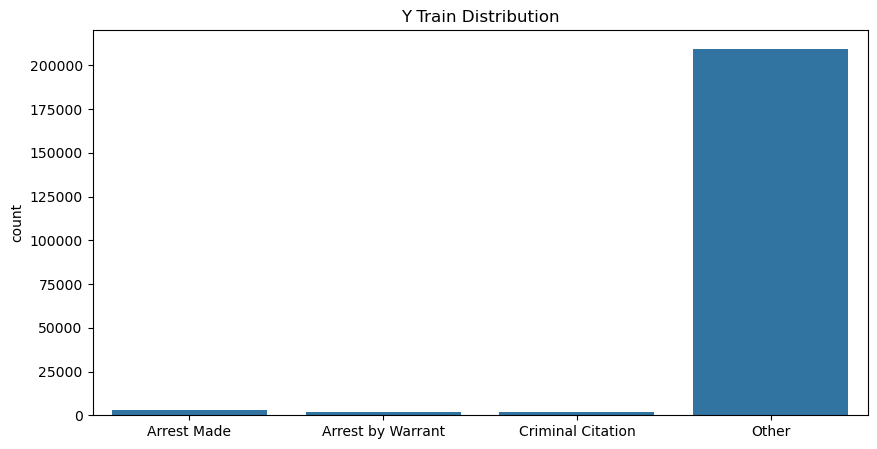

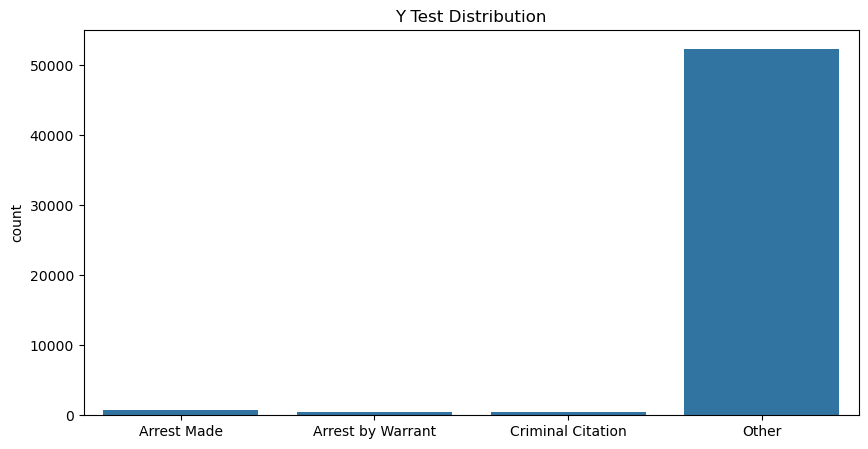

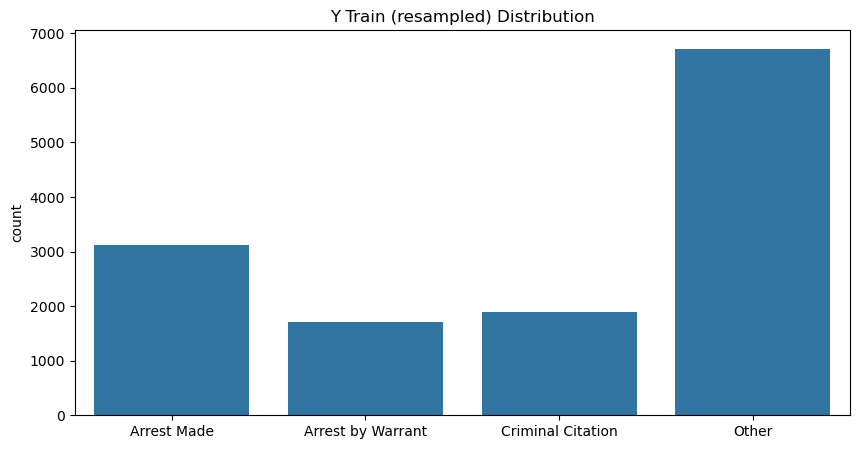

In [59]:
# Count the occurrences of each class in y_train and y_test
train_counts = collections.Counter(y_train)
test_counts = collections.Counter(y_test)

print("y_train distribution:", train_counts)
print("y_test distribution:", test_counts)

train_resampled_counts = collections.Counter(y_train_resampled)

print("y_train_resampled distribution:", train_counts)

# Bar plot for y_train
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train Distribution')
plt.show()

# Bar plot for y_test
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_test)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Test Distribution')
plt.show()

# Bar plot for y_train_resampled
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train_resampled)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train (resampled) Distribution')
plt.show()

## Evaluate Different Baseline Models

### Most Frequent Class Model

In [62]:
# Step 1: Find the most frequent class in the training set
most_frequent_class = np.bincount(y_train).argmax()

In [63]:
# Step 2: Predict the most frequent class for all samples in the test set
y_pred_baseline = [most_frequent_class] * len(y_test)

In [66]:
# Step 3: Evaluate the baseline model
print("Baseline Model (Most Frequent Class) Classification Report:")
print(classification_report(y_test, y_pred_baseline, zero_division=0, target_names=label_names))

Baseline Model (Most Frequent Class) Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.00      0.00      0.00       781
Arrest by Warrant       0.00      0.00      0.00       426
Criminal Citation       0.00      0.00      0.00       473
            Other       0.97      1.00      0.98     52384

         accuracy                           0.97     54064
        macro avg       0.24      0.25      0.25     54064
     weighted avg       0.94      0.97      0.95     54064



### Logistic Regression

In [69]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [70]:
y_pred_lr = lr_model.predict(X_test)
print("DONE")

DONE


In [75]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0, target_names=label_names))

Logistic Regression Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.12      0.60      0.20       781
Arrest by Warrant       0.42      0.58      0.49       426
Criminal Citation       0.18      0.56      0.28       473
            Other       0.99      0.91      0.95     52384

         accuracy                           0.90     54064
        macro avg       0.43      0.66      0.48     54064
     weighted avg       0.97      0.90      0.93     54064



#### Hyperparameter Tuning

In [77]:
grid_search_scoring_method = 'f1_macro'

In [78]:
# Define parameter grid
param_grid_lr = {
    'C': [0.1, 1, 10]
}

grid_lr = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=42), param_grid=param_grid_lr, 
                              cv=5, n_jobs=2, verbose=1, scoring=grid_search_scoring_method)

grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=2, param_grid={'C': [0.1, 1, 10]}, scoring='f1_macro',
             verbose=1)

In [79]:
# Best parameters and score
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_lr.best_score_:.4f}")

Best Parameters: {'C': 10}
Best Score (f1_macro): 0.5509


In [80]:
# Use the best estimator to make predictions
best_lr = grid_lr.best_estimator_

# save
joblib.dump(best_lr, f"models/{year}/best_logistic_regression.pkl") 

['models/2021/best_logistic_regression.pkl']

In [81]:
# load
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")

In [82]:
y_pred_best_lr = best_lr.predict(X_test)

# Evaluate the best model
print("Best Logistic Regression Classification Report for Police Calls:")
print(classification_report(y_test, y_pred_best_lr, zero_division=0, target_names=label_names))

Best Logistic Regression Classification Report for Police Calls:
                   precision    recall  f1-score   support

      Arrest Made       0.55      0.23      0.32       781
Arrest by Warrant       0.60      0.52      0.56       426
Criminal Citation       0.54      0.25      0.34       473
            Other       0.98      0.99      0.99     52384

         accuracy                           0.97     54064
        macro avg       0.67      0.50      0.55     54064
     weighted avg       0.97      0.97      0.97     54064



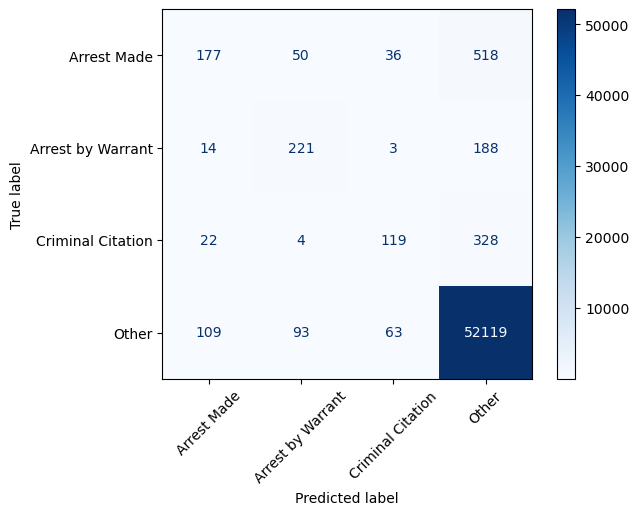

In [83]:
ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, display_labels=label_names, xticks_rotation=45, cmap=plt.cm.Blues)

#### Feature Importance

In [85]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance on sample data to speed things up

# Sample 20% of X_test and y_test
sample_size = int(0.2 * len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)

# Get the positional indices from the sample, and use them to index the numpy array y_test
pos_indices = X_test.index.get_indexer(X_test_sample.index)
y_test_sample = y_test[pos_indices]

permutation_importance_result = permutation_importance(best_lr, X_test_sample, y_test_sample, n_repeats=3, random_state=42)

In [86]:
# Create a DataFrame to store the feature importance results
importance_df = pd.DataFrame({
    'feature': X_test_sample.columns,
    'importance_mean': permutation_importance_result.importances_mean
})

# Define a mapping of one-hot encoded columns to their original categorical feature
# This is a dictionary where keys are the original feature names, and values are lists of one-hot encoded columns
one_hot_mapping = {
    'CALLTYPE_CODE': [col for col in X_test_sample.columns if col.startswith("CALLTYPE_CODE_")],
    'neighborhood': [col for col in X_test_sample.columns if col.startswith("neighborhood_")]
}

# Initialize a list to store aggregated and non-one-hot encoded features
final_importance = []

# 1. Aggregate the importance for one-hot encoded features
for original_feature, encoded_columns in one_hot_mapping.items():
    # Sum the importance of the one-hot encoded columns for this feature
    aggregated_importance = importance_df.loc[importance_df['feature'].isin(encoded_columns), 'importance_mean'].sum()
    final_importance.append({
        'feature': original_feature,
        'importance_mean': aggregated_importance
    })

# 2. Add the importance of the non-one-hot encoded features
# Find columns that are not part of the one-hot encoded mappings
all_one_hot_encoded_columns = [col for sublist in one_hot_mapping.values() for col in sublist]
non_one_hot_encoded_features = importance_df.loc[~importance_df['feature'].isin(all_one_hot_encoded_columns)]

# Append non-one-hot encoded features' importance to the final list
for _, row in non_one_hot_encoded_features.iterrows():
    final_importance.append({
        'feature': row['feature'],
        'importance_mean': row['importance_mean']
    })

# Convert final importance list to a DataFrame
final_importance_df = pd.DataFrame(final_importance)

# Sort by importance for easier interpretation
final_importance_df = final_importance_df.sort_values(by='importance_mean', ascending=False)

In [87]:
# Use display to see the dataframe nicely formatted
from IPython.display import display
display(final_importance_df)

,feature,importance_mean
0,CALLTYPE_CODE,0.014613
1,neighborhood,0.002220
2,PRIORITY,0.001326
5,DISTANCE_FROM_CENTER,0.000432
3,LATITUDE,0.000185
4,LONGITUDE,0.000185
6,LATITUDE^2,0.000154
9,AFTER_COVID_Yes,0.000000
8,LONGITUDE^2,-0.000216
7,LATITUDE LONGITUDE,-0.000339


In [88]:
# Set maximum number of rows to display
pd.set_option('display.max_rows', 200)

In [91]:
feature_names = X_train.columns

call_types = []
for feature_name in feature_names:
    if feature_name.startswith("CALLTYPE_CODE_"):
        code = feature_name[14:]
        call_type = call_type_code_mapping.get(code, '')
        call_types.append(call_type)
    else:
        call_types.append("")

# Create a DataFrame of the results
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': permutation_importance_result.importances_mean,
    'Call Type': call_types
})

# Sort by importance and display the top features
top_perm_features = perm_importance_df.sort_values(by='Importance', ascending=False).head(100)
print(top_perm_features)

                                          Feature  Importance  \
199                              CALLTYPE_CODE_6F    0.003515   
200                              CALLTYPE_CODE_6M    0.002806   
59                            CALLTYPE_CODE_11300    0.001572   
0                                        PRIORITY    0.001326   
64                            CALLTYPE_CODE_11377    0.001017   
131                            CALLTYPE_CODE_3056    0.000524   
80                            CALLTYPE_CODE_12020    0.000462   
3                            DISTANCE_FROM_CENTER    0.000432   
61                            CALLTYPE_CODE_11350    0.000339   
102                           CALLTYPE_CODE_22500    0.000339   
83                            CALLTYPE_CODE_12500    0.000308   
107                           CALLTYPE_CODE_23152    0.000308   
8                             CALLTYPE_CODE_1033A    0.000277   
81                           CALLTYPE_CODE_12020G    0.000277   
67                       

In [93]:
for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })
    
    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(50)
    
    # Display the top most important features
    print(f"\nlabel = {label_names[index]}")
    print(top_features[['Display Name', 'Coefficient']])


label = Arrest Made
                                          Display Name  Coefficient
107                         Call Type: MISDEMEANOR DUI     3.299342
87           Call Type: RESISTING ARREST, GANG RELATED     2.897368
82              Call Type: CARRYING A CONCEALED WEAPON     2.776071
225           Call Type: VIOLATION OF PROTECTIVE ORDER     2.438106
8                            Call Type: ALARM, AUDIBLE    -2.416210
129            Call Type: REGISTRATION OF SEX OFFENDER     2.384716
117                   Call Type: BATTERY ON AN OFFICER     2.341260
83                        Call Type: UNLICENSED DRIVER    -2.249101
108                              Call Type: FELONY DUI     2.206890
206                       Call Type: UNK TYPE 911 CALL    -2.190551
80                          Call Type: ILLEGAL WEAPONS     2.177993
76                   Call Type: VEHICLE STOP ON FEMALE    -2.106486
120              Call Type: ASSAULT WITH DEADLY WEAPON     2.074263
102                       C

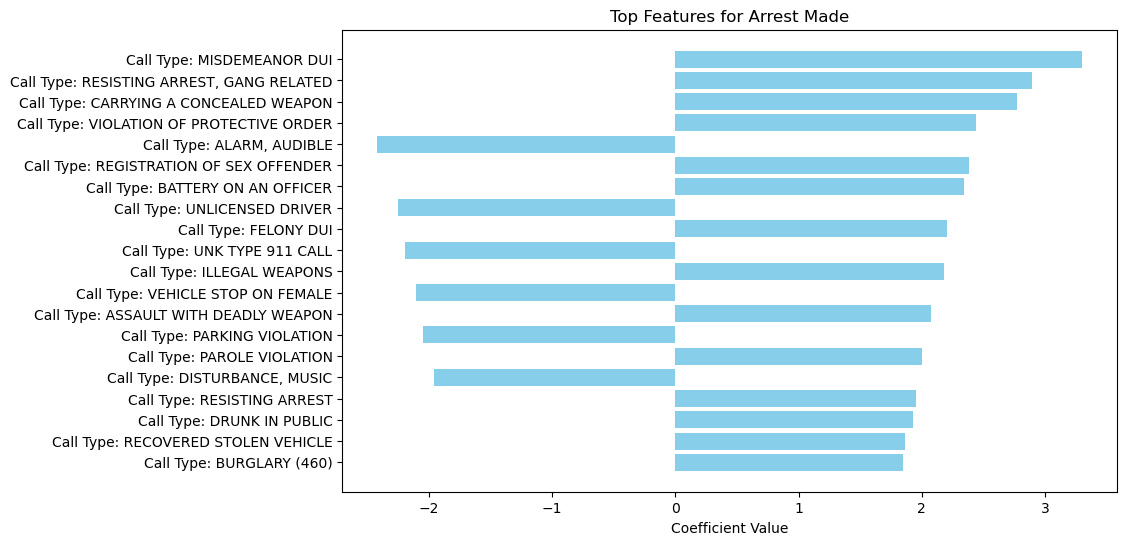

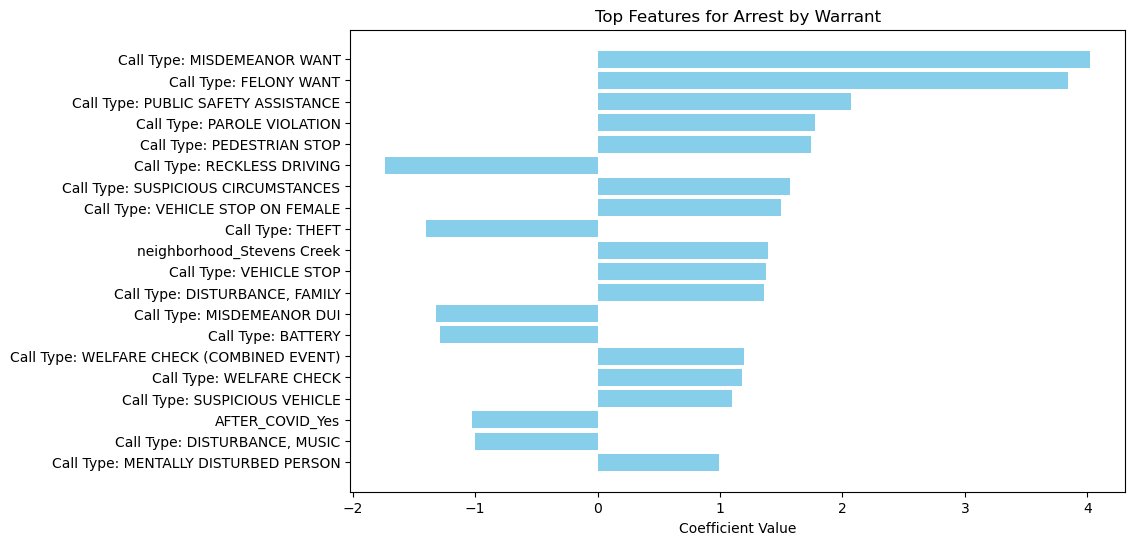

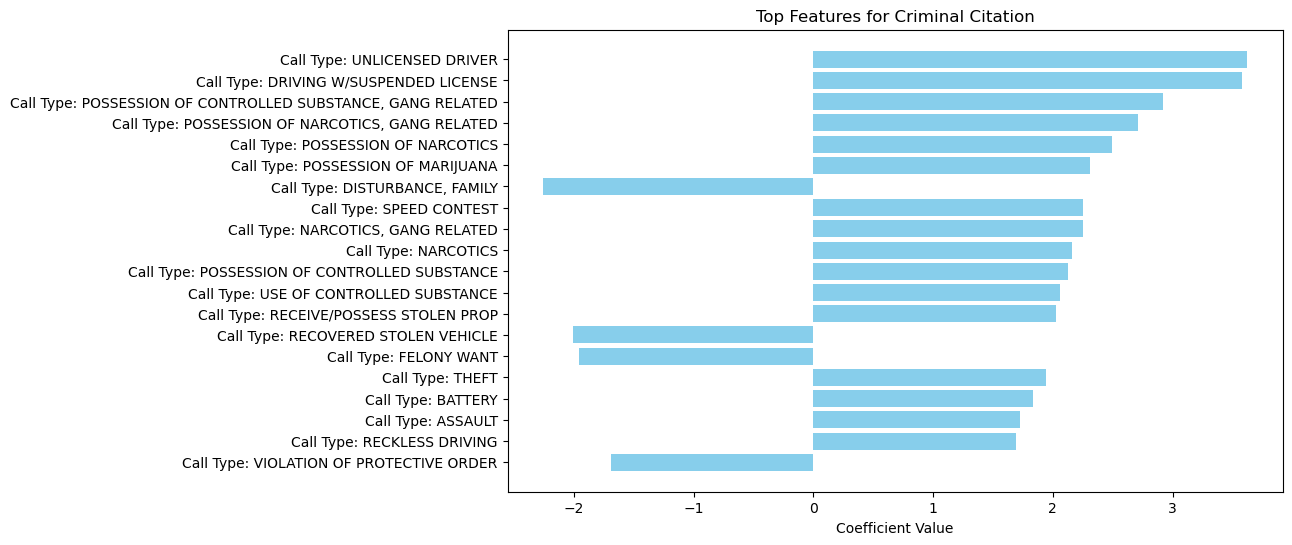

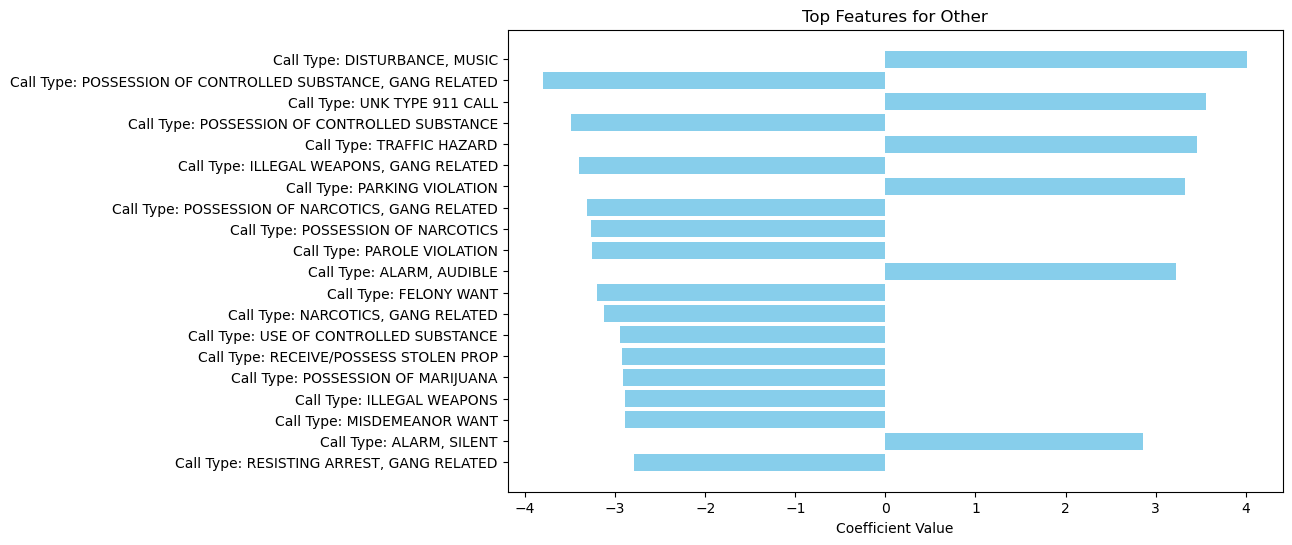

In [95]:
import matplotlib.pyplot as plt

for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })

    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(20)
    
    # Plot the top coefficients as a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Display Name'], top_features['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top Features for {label_names[index]}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
    plt.show()


### Random Forest

In [97]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [98]:
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0, target_names=label_names))

Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.40      0.23      0.29       781
Arrest by Warrant       0.55      0.41      0.47       426
Criminal Citation       0.43      0.25      0.31       473
            Other       0.98      0.99      0.99     52384

         accuracy                           0.97     54064
        macro avg       0.59      0.47      0.51     54064
     weighted avg       0.96      0.97      0.97     54064



#### Hyperparameter Tuning and Cross Validation

In [100]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 60],
}

# Initialize Grid Search
grid_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, n_jobs=-1,
                              cv=5, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_rf.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_rf.best_score_:.2f}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'n_estimators': 50}
Best Score (f1_macro): 0.52


In [101]:
best_rf = grid_rf.best_estimator_

In [102]:
# save
joblib.dump(best_rf, f"models/{year}/best_random_forest.pkl") 

['models/2021/best_random_forest.pkl']

In [103]:
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")

In [104]:
# Use the best estimator to make predictions
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.40      0.23      0.29       781
Arrest by Warrant       0.53      0.39      0.45       426
Criminal Citation       0.42      0.25      0.31       473
            Other       0.98      0.99      0.99     52384

         accuracy                           0.97     54064
        macro avg       0.58      0.47      0.51     54064
     weighted avg       0.96      0.97      0.97     54064



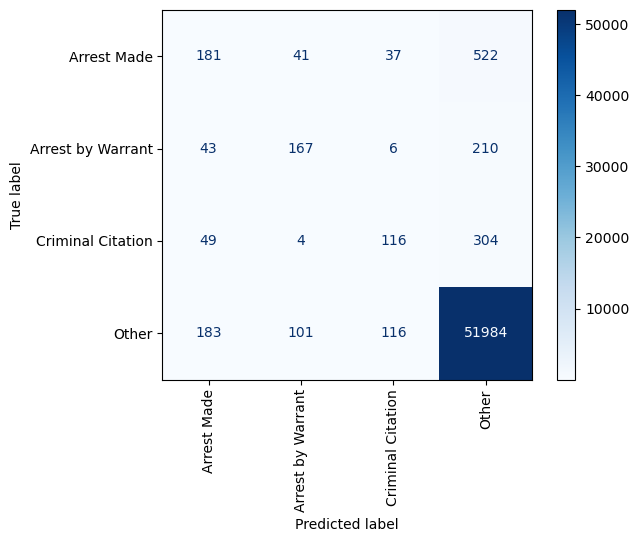

In [105]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)

plt.show()

In [106]:
#### Optuna

def rf_objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 100)
    max_depth = trial.suggest_int('max_depth', 5, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    # Initialize RandomForest with suggested hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    # Use cross-validation to evaluate the model
    score = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=5, scoring='f1_macro').mean()
    return score

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(rf_objective, n_trials=20)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-10-08 13:26:14,285] A new study created in memory with name: no-name-254b1e3c-40d6-4931-89e1-42ae91d43ebb
[I 2024-10-08 13:26:15,362] Trial 0 finished with value: 0.6447928871853219 and parameters: {'n_estimators': 52, 'max_depth': 89, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.6447928871853219.
[I 2024-10-08 13:26:16,579] Trial 1 finished with value: 0.6748139283081919 and parameters: {'n_estimators': 76, 'max_depth': 73, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6748139283081919.
[I 2024-10-08 13:26:17,879] Trial 2 finished with value: 0.6516489686785432 and parameters: {'n_estimators': 82, 'max_depth': 97, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.6748139283081919.
[I 2024-10-08 13:26:19,082] Trial 3 finished with value: 0.6566088768552225 and parameters: {'n_estimators': 100, 'max_depth': 93, 'mi

Best hyperparameters: {'n_estimators': 76, 'max_depth': 73, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


In [107]:
best_params = study.best_params
best_params

{'n_estimators': 76,
 'max_depth': 73,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt'}

In [108]:
# Train the RandomForest using the best hyperparameters
best_rf_2 = RandomForestClassifier(**best_params, n_jobs=-1)
best_rf_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=73, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=76, n_jobs=-1)

In [109]:
# Use the best estimator to make predictions
y_pred_best_rf_2 = best_rf_2.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf_2, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.58      0.18      0.27       781
Arrest by Warrant       0.60      0.55      0.58       426
Criminal Citation       0.53      0.20      0.29       473
            Other       0.98      1.00      0.99     52384

         accuracy                           0.97     54064
        macro avg       0.67      0.48      0.53     54064
     weighted avg       0.97      0.97      0.97     54064



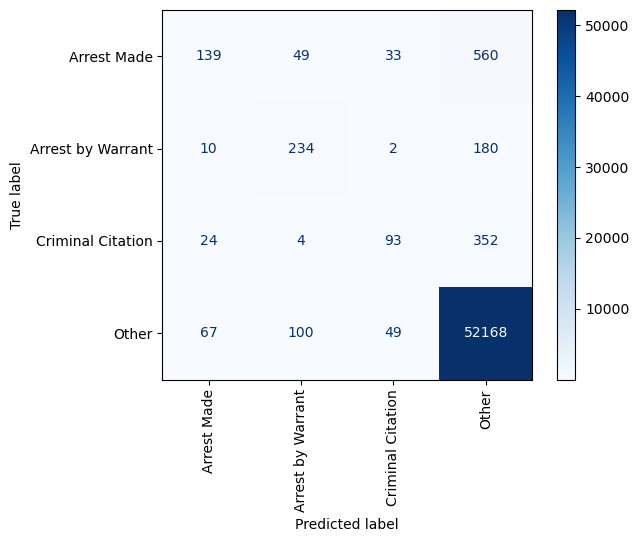

In [110]:
ConfusionMatrixDisplay.from_estimator(best_rf_2, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)
plt.show()

#### Feature Importance

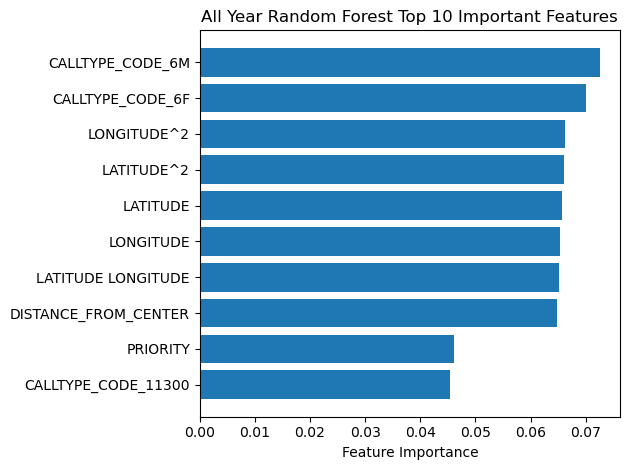

In [112]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances and sort them in descending order
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Select top 10 features

# Create a bar chart for the top 10 features
plt.barh(np.array(feature_names)[indices], importances[indices])
plt.xlabel('Feature Importance')
plt.title('All Year Random Forest Top 10 Important Features')
plt.tight_layout()  # Adjusts the padding automatically
plt.savefig('images/all_year_random_forest_feature_importance.png')
plt.show()

### Multilayer Perceptron Model

In [114]:
# Set up early stopping and model checkpoint callbacks so we choose the best model

# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=3,          # stop training if val_loss doesn't improve for N epochs
    restore_best_weights=True  # restore model to the epoch with the best val_loss
)

# Save the best model
model_checkpoint = ModelCheckpoint(
    'best_model.mcp.keras',    # path to save the best model
    monitor='val_loss', # monitor validation loss
    save_best_only=True # only save the model with the best val_loss
)

In [115]:
# Build the MLP model
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [116]:
# Train the model
history = mlp_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
2704/2704 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9656 - loss: 0.1580 - val_accuracy: 0.9726 - val_loss: 0.1059
Epoch 2/20
2704/2704 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9732 - loss: 0.1055 - val_accuracy: 0.9732 - val_loss: 0.1012
Epoch 3/20
2704/2704 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9743 - loss: 0.1003 - val_accuracy: 0.9735 - val_loss: 0.1013
Epoch 4/20
2704/2704 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9742 - loss: 0.0983 - val_accuracy: 0.9735 - val_loss: 0.1020
Epoch 5/20
2704/2704 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9751 - loss: 0.0946 - val_accuracy: 0.9732 - val_loss: 0.1037


In [117]:
# save
joblib.dump(mlp_model, f"models/{year}/mlp_model.pkl") 

['models/2021/mlp_model.pkl']

In [118]:
mlp_model = joblib.load(f"models/{year}/mlp_model.pkl")

In [119]:
# Evaluate on test data
test_loss, test_acc = mlp_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

1690/1690 ━━━━━━━━━━━━━━━━━━━━ 1s 469us/step - accuracy: 0.9729 - loss: 0.1048
Test Accuracy: 0.9737


In [120]:
# Make predictions
y_pred_nn = mlp_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Classification report
print("Multilayer Perceptron Classification Report:")
print(classification_report(y_test, y_pred_nn_classes, zero_division=0, target_names=label_names))

1690/1690 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step
Multilayer Perceptron Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.59      0.19      0.28       781
Arrest by Warrant       0.60      0.54      0.57       426
Criminal Citation       0.56      0.16      0.25       473
            Other       0.98      1.00      0.99     52384

         accuracy                           0.97     54064
        macro avg       0.68      0.47      0.52     54064
     weighted avg       0.97      0.97      0.97     54064



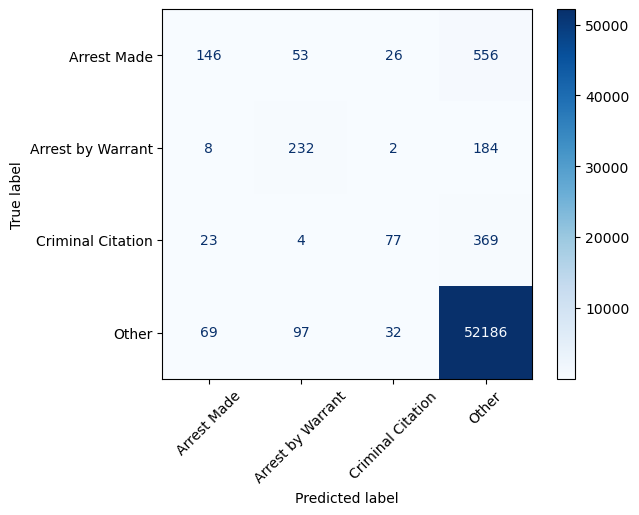

In [121]:
cm = confusion_matrix(y_test, y_pred_nn_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

### XGBoost

In [124]:
def objective(trial):
    params = {
        'n_estimators': 300,
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }
    
    xgb_clf = XGBClassifier(**params, eval_metric='logloss')
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    try:
        scores = cross_val_score(xgb_clf, X_train_resampled, y_train_resampled, scoring='f1_macro', cv=cv, n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"An error occurred: {e}")
        return float('-inf')

# Create a study object and specify the direction is 'maximize' for f1_macro score
study = optuna.create_study(direction='maximize')

# Number of trials
n_trials = 20

# Optimize the study
start_time = time.time()
study.optimize(objective, n_trials=n_trials, n_jobs=1, catch=(Exception,))
end_time = time.time()

actual_runtime = end_time - start_time
print(f"Actual runtime: {actual_runtime:.2f} seconds ({actual_runtime/60:.2f} minutes)")

# Print the best parameters and score
print("Best parameters found: ", study.best_params)
print("Best F1 macro score: ", study.best_value)

[I 2024-10-08 13:27:29,224] A new study created in memory with name: no-name-33cfb0e0-58ba-4555-8f4c-f7ffc3a66cce
[I 2024-10-08 13:27:57,276] Trial 0 finished with value: 0.6301539470383878 and parameters: {'learning_rate': 0.25331582570766936, 'max_depth': 9, 'subsample': 0.8209485822466813, 'colsample_bytree': 0.6528448411015763, 'gamma': 0.007612627586604529, 'reg_alpha': 0.19830430908281213, 'reg_lambda': 6.528978896779499e-06}. Best is trial 0 with value: 0.6301539470383878.
[I 2024-10-08 13:28:17,755] Trial 1 finished with value: 0.6223588229714581 and parameters: {'learning_rate': 0.48566566645581716, 'max_depth': 8, 'subsample': 0.6452480535806714, 'colsample_bytree': 0.9022998501443553, 'gamma': 0.12008124805714594, 'reg_alpha': 1.6936061785281107e-05, 'reg_lambda': 0.0820363681234671}. Best is trial 0 with value: 0.6301539470383878.
[I 2024-10-08 13:28:31,898] Trial 2 finished with value: 0.6397155820491124 and parameters: {'learning_rate': 0.01780586258587297, 'max_depth': 4

Actual runtime: 412.50 seconds (6.87 minutes)
Best parameters found:  {'learning_rate': 0.05196029969372067, 'max_depth': 5, 'subsample': 0.8167163110503662, 'colsample_bytree': 0.925308310589617, 'gamma': 4.668985100589732e-07, 'reg_alpha': 0.00028548409631516214, 'reg_lambda': 1.334875666922184e-07}
Best F1 macro score:  0.6781213561744982


In [125]:
# train the final model with the best parameters:
best_params = study.best_params
xgb_1_model = XGBClassifier(**best_params, eval_metric='logloss')
xgb_1_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.925308310589617, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=4.668985100589732e-07, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05196029969372067, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [126]:
y_pred_best_xgb = xgb_1_model.predict(X_test)

xgb_1_accuracy = accuracy_score(y_test, y_pred_best_xgb)
xgb_1_recall = recall_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_prec = precision_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_f1 = f1_score(y_test, y_pred_best_xgb, average='macro')

# Evaluate the best model
print("Best XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb, zero_division=0, target_names=label_names))

Best XGBoost Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.62      0.03      0.06       781
Arrest by Warrant       0.62      0.54      0.57       426
Criminal Citation       0.59      0.10      0.18       473
            Other       0.98      1.00      0.99     52384

         accuracy                           0.97     54064
        macro avg       0.70      0.42      0.45     54064
     weighted avg       0.96      0.97      0.96     54064



In [127]:
best_xg = xgb_1_model
joblib.dump(best_xg, f"models/{year}/xgb_model.pkl") 

['models/2021/xgb_model.pkl']

In [128]:
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

## Ensemble

In [130]:
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

In [131]:
print(f'LR F1: {f1_score(y_test, best_lr.predict(X_test), average='macro')}')
print(f'RF F1: {f1_score(y_test, best_rf.predict(X_test), average='macro')}')
print(f'XGB F1: {f1_score(y_test, best_xg.predict(X_test), average='macro')}')

LR F1: 0.552062236948984
RF F1: 0.5102855649236248
XGB F1: 0.4481386295871519


In [132]:
best_lr

LogisticRegression(C=10, max_iter=1000, random_state=42)

In [133]:
best_rf

RandomForestClassifier(n_estimators=50)

In [134]:
best_xg

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.925308310589617, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=4.668985100589732e-07, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05196029969372067, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [135]:
estimators = [
    ('lr', best_lr),
    ('rf', best_rf),
    ('xg', best_xg)
]

base_estimators_fitted = [best_lr, best_rf, best_xg]

In [136]:
X_train_float = X_train.astype('float64')

In [137]:
stacking_clf_2 = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(), n_jobs=2)
stacking_clf_2.fit(X_train_float, y_train)

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=10, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=50)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.925308310589617,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              ev...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   n_jobs=2)

In [138]:
joblib.dump(stacking_clf_2, f"models/{year}/stacking_2.pkl") 

['models/2021/stacking_2.pkl']

In [139]:
stacking_clf_2 = joblib.load(f"models/{year}/stacking_2.pkl")

In [140]:
y_pred_stacking_2 = stacking_clf_2.predict(X_test)
stack_2_accuracy = accuracy_score(y_test, y_pred_stacking_2)
stack_2_recall = recall_score(y_test, y_pred_stacking_2, average='macro')
stack_2_prec = precision_score(y_test, y_pred_stacking_2, average='macro')
stack_2_f1 = f1_score(y_test, y_pred_stacking_2, average='macro')
print(f"Stacking Classifier F1 Score: {stack_2_f1}")

Stacking Classifier F1 Score: 0.5646328641380036


In [141]:
print("Ensemble Classification Report:")
print(classification_report(y_test, y_pred_stacking_2, zero_division=0, target_names=label_names))

Ensemble Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.58      0.26      0.36       781
Arrest by Warrant       0.62      0.54      0.57       426
Criminal Citation       0.50      0.26      0.34       473
            Other       0.98      0.99      0.99     52384

         accuracy                           0.97     54064
        macro avg       0.67      0.51      0.56     54064
     weighted avg       0.97      0.97      0.97     54064



## Results

In [143]:
from sklearn.metrics import f1_score

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
lr_accuracy = accuracy_score(y_test, y_pred_best_lr)
rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
mlp_accuracy = accuracy_score(y_test, y_pred_nn_classes)

baseline_recall = recall_score(y_test, y_pred_baseline, average='macro')
lr_recall = recall_score(y_test, y_pred_best_lr, average='macro')
rf_recall = recall_score(y_test, y_pred_best_rf, average='macro')
mlp_recall = recall_score(y_test, y_pred_nn_classes, average='macro')

baseline_prec = precision_score(y_test, y_pred_baseline, average='macro', zero_division=0)
lr_prec = precision_score(y_test, y_pred_best_lr, average='macro', zero_division=0)
rf_prec = precision_score(y_test, y_pred_best_rf, average='macro', zero_division=0)
mlp_prec = precision_score(y_test, y_pred_nn_classes, average='macro', zero_division=0)

baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')
lr_f1 = f1_score(y_test, y_pred_best_lr, average='macro')
rf_f1 = f1_score(y_test, y_pred_best_rf, average='macro')
mlp_f1 = f1_score(y_test, y_pred_nn_classes, average='macro')

results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest', 'MLP', 'XGB', 'Ensemble'],
    'Accuracy': [baseline_accuracy, lr_accuracy, rf_accuracy, mlp_accuracy, xgb_1_accuracy, stack_2_accuracy],
    'Recall': [baseline_recall, lr_recall, rf_recall, mlp_recall, xgb_1_recall, stack_2_recall],
    'Precision': [baseline_prec, lr_prec, rf_prec, mlp_prec, xgb_1_prec, stack_2_prec],
    'F1-score': [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_2_f1]
})
results.set_index('Model')

,Accuracy,Recall,Precision,F1-score
Model,,,,
Baseline,0.968926,0.250000,0.242231,0.246054
Logistic Regression,0.973587,0.497985,0.667310,0.552062
Random Forest,0.970109,0.465345,0.583189,0.510286
MLP,0.973679,0.472638,0.683942,0.523961
XGB,0.972237,0.416486,0.701345,0.448139
Ensemble,0.973901,0.511386,0.669346,0.564633


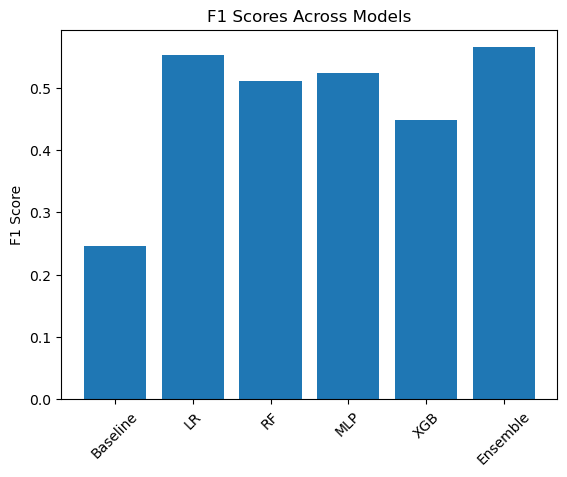

In [144]:
model_names = ['Baseline', 'LR', 'RF', 'MLP', 'XGB', 'Ensemble']
f1_scores = [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_2_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title('F1 Scores Across Models')
plt.show()

## Comparison with the All-Year Models

In [146]:
all_yr_lr = joblib.load("models/all_yr_best_logistic_regression.pkl")
all_yr_rf = joblib.load("models/all_yr_best_random_forest.pkl")
all_yr_xg = joblib.load("models/all_yr_xgb_model.pkl")
all_yr_stack = joblib.load("models/all_yr_stacking_2.pkl")

In [147]:
all_yr_lr_f1 = f1_score(y_test, all_yr_lr.predict(X_test), average='macro')
all_yr_rf_f1 = f1_score(y_test, all_yr_rf.predict(X_test), average='macro')
all_yr_xg_f1 = f1_score(y_test, all_yr_xg.predict(X_test), average='macro')
all_yr_stack_f1 = f1_score(y_test, all_yr_stack.predict(X_test), average='macro')

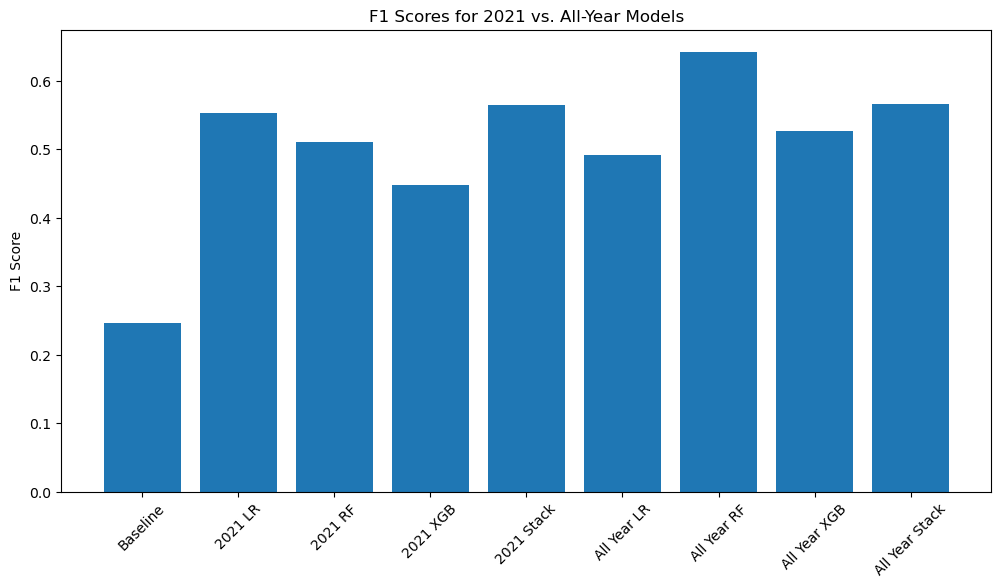

In [148]:
plt.figure(figsize=(12, 6))  # Adjust the width (12) and height (6) as needed

model_names = ['Baseline', f'{year} LR', f'{year} RF', f'{year} XGB', f'{year} Stack', 'All Year LR', 'All Year RF', 'All Year XGB', 'All Year Stack']
f1_scores = [baseline_f1, lr_f1, rf_f1, xgb_1_f1, stack_2_f1, all_yr_lr_f1, all_yr_rf_f1, all_yr_xg_f1, all_yr_stack_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. All-Year Models')
plt.show()

## 2021 vs. Non-2021 Models

In [150]:
other_years = [y for y in range(2013, 2025) if str(y) != year]
other_years

[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2022, 2023, 2024]

In [151]:
other_years_df = model_utils.load_data(other_years)
model_utils.transform_offense_date(other_years_df)
dispo_mapping = model_utils.calc_dispo_subset(other_years_df)
all_police_df.shape

(302119, 24)

In [152]:
other_years_clean = model_utils.clean_and_transform_data(other_years_df)
other_years_clean.shape

Police Calls Dataset: 3284738 rows before cleaning, 2930642 rows after cleaning.


(2930642, 15)

In [153]:
X_train_oy, X_test_oy, y_train_oy, y_test_oy, _, _, X_train_resampled_oy, y_train_resampled_oy, _ = \
    model_utils.split_data(other_years_clean, dispo_mapping, encoder)

classes = ['A' 'B' 'C' 'Other']
(2344513, 14)
(586129, 14)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Counter({3: 2247669, 0: 49476, 2: 26799, 1: 20569})
Counter({3: 96844, 0: 49476, 2: 26799, 1: 20569})


In [154]:
rf_model_oy = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model_oy.fit(X_train_oy, y_train_oy)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [155]:
y_pred_rf_oy = rf_model_oy.predict(X_test_oy)

print(f"Random Forest Other Years Classification Report for Non-{year} Data:")
print(classification_report(y_test_oy, y_pred_rf_oy, zero_division=0, target_names=label_names))

Random Forest Other Years Classification Report for Non-2021 Data:
                   precision    recall  f1-score   support

      Arrest Made       0.56      0.38      0.45     12369
Arrest by Warrant       0.69      0.54      0.61      5142
Criminal Citation       0.46      0.22      0.30      6700
            Other       0.98      0.99      0.98    561918

         accuracy                           0.97    586129
        macro avg       0.67      0.53      0.58    586129
     weighted avg       0.96      0.97      0.96    586129



In [156]:
y_pred_rf_oy_2021 = rf_model_oy.predict(X_test)

print(f"Random Forest Other Years Classification Report for {year} Data:")
print(classification_report(y_test, y_pred_rf_oy_2021, zero_division=0, target_names=label_names))

Random Forest Other Years Classification Report for 2021 Data:
                   precision    recall  f1-score   support

      Arrest Made       0.44      0.23      0.30       781
Arrest by Warrant       0.60      0.47      0.53       426
Criminal Citation       0.47      0.22      0.30       473
            Other       0.98      0.99      0.99     52384

         accuracy                           0.97     54064
        macro avg       0.62      0.48      0.53     54064
     weighted avg       0.97      0.97      0.97     54064



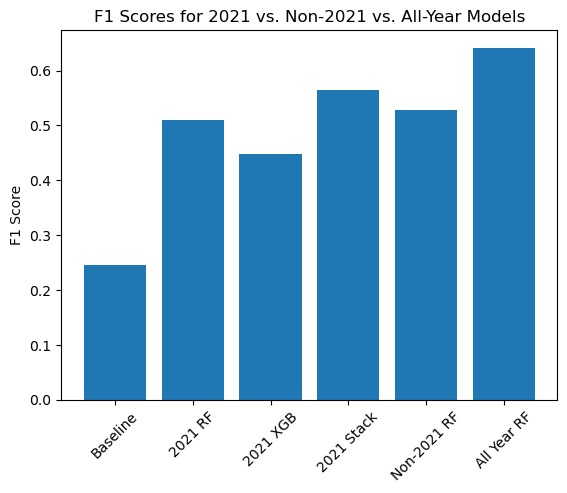

In [157]:
model_names = ['Baseline', f'{year} RF', f'{year} XGB', f'{year} Stack', f'Non-{year} RF', 'All Year RF']
f1_scores = [baseline_f1, rf_f1, xgb_1_f1, stack_2_f1, f1_score(y_test, y_pred_rf_oy_2021, average='macro'), all_yr_rf_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. Non-{year} vs. All-Year Models')
plt.show()